## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    x = input_layer
    for i, n_units in enumerate(num_neurons):
        x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
        x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

def plot_results(results):
    NUM_COLORS = len(results.keys())

    cm = plt.get_cmap('gist_rainbow')
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [('SGD', keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95)),
                 ('Adam', keras.optimizers.Adam(lr=LEARNING_RATE)),
                 ('RMSprop', keras.optimizers.RMSprop(lr=LEARNING_RATE))]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.3]
redice_lr_patient = [3, 8]

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
import itertools
results = {}
for i, ((name, optim), reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, opt: %s, reduce_factor: %.2f, reduce_patient: %i" % (i, name, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%i-%s-%.2f-%i" % (i, name, reduce_factor, reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, opt: SGD, reduce_factor: 0.10, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_no

50000/50000 [==============================] - 2s 49us/step - loss: 1.7220 - acc: 0.4018 - val_loss: 1.7735 - val_acc: 0.3843
Epoch 12/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.7019 - acc: 0.4073 - val_loss: 1.7583 - val_acc: 0.3893
Epoch 13/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6830 - acc: 0.4131 - val_loss: 1.7440 - val_acc: 0.3932
Epoch 14/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6652 - acc: 0.4189 - val_loss: 1.7317 - val_acc: 0.3958
Epoch 15/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6514 - acc: 0.4241 - val_loss: 1.7210 - val_acc: 0.4015
Epoch 16/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6371 - acc: 0.4279 - val_loss: 1.7106 - val_acc: 0.4051
Epoch 17/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6232 - acc: 0.4322 - val_loss: 1.6996 - val_acc: 0.4087
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.6249 - acc: 0.1624 - val_loss: 2.5101 - val_acc: 0.2160
Epoch 2/25
50000/50000 [==============================] - 2s 48us/step - loss: 2.2288 - acc: 0.2551 - val_loss: 2.1945 - val_acc: 0.2700
Epoch 3/25
50000/50000 [==============================] - 2s 48us/step - loss: 2.0680 - acc: 0.2951 - val_loss: 2.0787 - val_acc: 0.2995
Epoch 4/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.9755 - acc: 0.3200 - val_loss: 2.0114 - val_acc: 0.3195
Epoch 5/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.9107 - acc: 0.3398 - val_loss: 1.9549 - val_acc: 0.3358
Epoch 6/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.8613 - acc: 0.3561 - val_loss: 1.9128 - val_acc: 0.3449
Epoch 7/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.8212 - acc: 0.3679 - val_loss: 1.8804 - val_acc

50000/50000 [==============================] - 3s 51us/step - loss: 0.9090 - acc: 0.6944 - val_loss: 1.3080 - val_acc: 0.5448
Epoch 23/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9086 - acc: 0.6947 - val_loss: 1.3083 - val_acc: 0.5440

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 24/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9073 - acc: 0.6952 - val_loss: 1.3085 - val_acc: 0.5437
Epoch 25/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9089 - acc: 0.6938 - val_loss: 1.3086 - val_acc: 0.5439
Numbers of exp: 5, opt: Adam, reduce_factor: 0.10, reduce_patient: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)     

Epoch 9/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.7534 - acc: 0.1397 - val_loss: 2.7134 - val_acc: 0.1484
Epoch 10/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.7371 - acc: 0.1438 - val_loss: 2.6996 - val_acc: 0.1524
Epoch 11/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.7216 - acc: 0.1462 - val_loss: 2.6868 - val_acc: 0.1558
Epoch 12/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.7079 - acc: 0.1493 - val_loss: 2.6743 - val_acc: 0.1581
Epoch 13/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.6958 - acc: 0.1515 - val_loss: 2.6628 - val_acc: 0.1602
Epoch 14/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.6830 - acc: 0.1550 - val_loss: 2.6517 - val_acc: 0.1630
Epoch 15/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.6721 - acc: 0.1571 - val_loss: 2.6411 - val_acc: 0.1652
Epoch 16/25
50000/50000 [==========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.8127 - acc: 0.3726 - val_loss: 2.1000 - val_acc: 0.3194
Epoch 2/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.5442 - acc: 0.4561 - val_loss: 2.3462 - val_acc: 0.2510
Epoch 3/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.4411 - acc: 0.4903 - val_loss: 2.1016 - val_acc: 0.3401
Epoch 4/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.3624 - acc: 0.5199 - val_loss: 1.9686 - val_acc: 0.3342
Epoch 5/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2999 - acc: 0.5398 - val_loss: 2.7782 - val_acc: 0.2412
Epoch 6/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2474 - acc: 0.5574 - val_loss: 2.0377 - val_acc: 0.3294
Epoch 7/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2049 - acc: 0.5731 - val_loss: 1.8240 - val_acc

50000/50000 [==============================] - 3s 51us/step - loss: 2.0436 - acc: 0.3005 - val_loss: 2.0747 - val_acc: 0.2962
Epoch 23/25
50000/50000 [==============================] - 3s 51us/step - loss: 2.0302 - acc: 0.3044 - val_loss: 2.0628 - val_acc: 0.2981
Epoch 24/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.0179 - acc: 0.3070 - val_loss: 2.0517 - val_acc: 0.3012
Epoch 25/25
50000/50000 [==============================] - 3s 51us/step - loss: 2.0051 - acc: 0.3122 - val_loss: 2.0409 - val_acc: 0.3040
Numbers of exp: 10, opt: RMSprop, reduce_factor: 0.30, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________

50000/50000 [==============================] - 3s 52us/step - loss: 2.3589 - acc: 0.2204 - val_loss: 2.3749 - val_acc: 0.2305
Epoch 10/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.3186 - acc: 0.2315 - val_loss: 2.3360 - val_acc: 0.2402
Epoch 11/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.2834 - acc: 0.2395 - val_loss: 2.3015 - val_acc: 0.2470
Epoch 12/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.2518 - acc: 0.2486 - val_loss: 2.2703 - val_acc: 0.2525
Epoch 13/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.2197 - acc: 0.2558 - val_loss: 2.2423 - val_acc: 0.2600
Epoch 14/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.1935 - acc: 0.2636 - val_loss: 2.2163 - val_acc: 0.2678
Epoch 15/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.1671 - acc: 0.2702 - val_loss: 2.1915 - val_acc: 0.2708
Epoch 16/25
50000/50000 [=====================

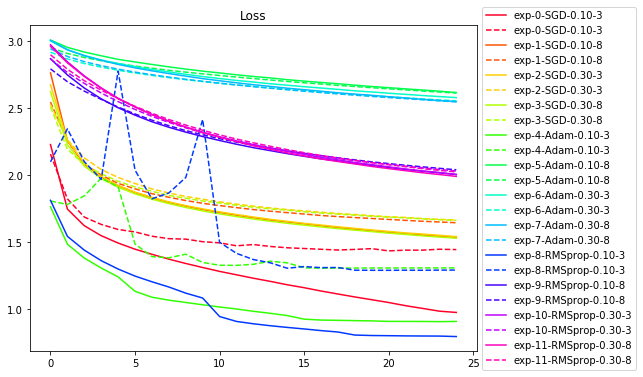

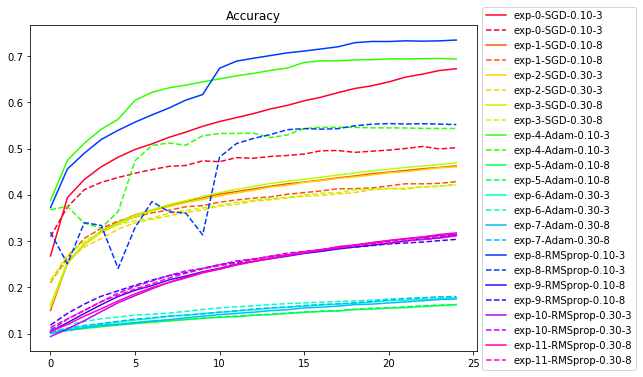

In [10]:
plot_results(results)